<h1> LOGISTIC REGRESSION IMPLEMENTATION <h1>

<h2> IMPORTS <h2>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import cupy as cp
import sklearn
from sklearn.model_selection import train_test_split


<h2> IMPORTS AND SPLIT <h2>

In [2]:
import os
os.chdir(r"C:\Users\Salaar Masood\OneDrive - Higher Education Commission\ML (CS438)\Proj\Progress\Urdu-News-Classification") # change to whatever your dir is
path = r"dataset/cleaned_articles/cleaned_articles_without_numbers_v2.csv"
data = pd.read_csv(path)

In [3]:
X = data['content']
Y = data['gold_label']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=501)
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"Y_test shape: {Y_test.shape}")


category_to_label = {
    "entertainment": 0,
    "business": 1,
    "sports": 2,
    "science-technology": 3,
    "international": 4
}

Y_train = [category_to_label[label.strip()] for label in Y_train if label.strip() in category_to_label]
Y_test = [category_to_label[label.strip()] for label in Y_test if label.strip() in category_to_label]


X_train shape: (2000,)
X_test shape: (501,)
Y_train shape: (2000,)
Y_test shape: (501,)


<h2> BAG OF WORDS <h2>

In [4]:
class TextProcessor:
    def __init__(self, dataset):
        self.dataset = dataset
        self.vocabulary = {}

    def build_vocabulary(self):
        unique_words = set()
        for sentence in self.dataset:
            unique_words.update(sentence.split())
        self.vocabulary = {word: idx for idx, word in enumerate(sorted(unique_words))}
        return self.vocabulary

    def sentence_to_bow(self, sentence):
        words = sentence.split()
        vector = np.zeros(len(self.vocabulary))
        for word in words:
            if word in self.vocabulary:
                index = self.vocabulary[word]
                # print(index)
                vector[index] += 1
        return vector

    def vectorize_sentences(self, X):
        return [self.sentence_to_bow(sentence) for sentence in X]


In [5]:
bag = TextProcessor(X_train)
vocab = bag.build_vocabulary()
train_x = bag.vectorize_sentences(X_train)
test_x = bag.vectorize_sentences(X_test)
# print("trainx", train_x[0][12242])
# print(vocab)

<h2> IMPLEMENTATION <h2>

Accuracy: 0.9641

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       107
           1       0.99      0.96      0.97        95
           2       1.00      0.94      0.97        85
           3       0.96      0.97      0.97       104
           4       0.95      0.98      0.96       110

    accuracy                           0.96       501
   macro avg       0.97      0.96      0.96       501
weighted avg       0.96      0.96      0.96       501



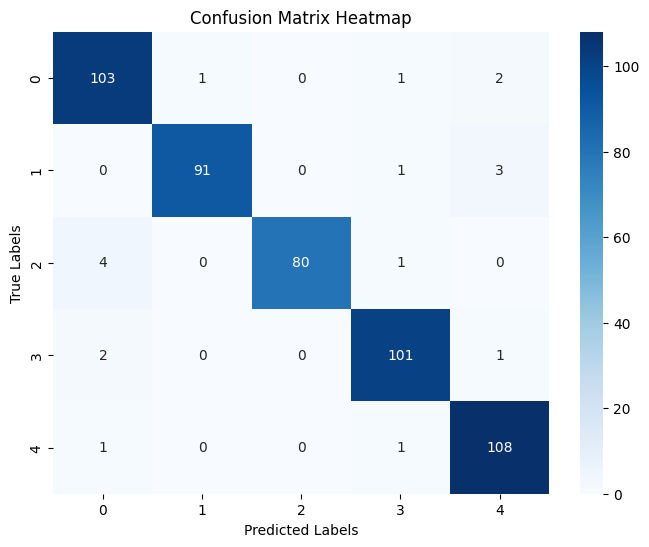

In [ ]:
# logistical regression with L2 regularization
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ensure train_x and test_x are NumPy arrays
train_x = np.array(train_x)
test_x = np.array(test_x)

class SoftmaxRegression:
    def __init__(self, learning_rate=0.005, n_iterations=2000, regularization_strength=0.05, batch_size=32, dropout_rate=0.2):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.regularization_strength = regularization_strength
        self.batch_size = batch_size
        self.dropout_rate = dropout_rate
        self.weights = None
        self.bias = None

    def softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def cross_entropy_loss(self, y_true, y_pred):
        n_samples = y_true.shape[0]
        log_likelihood = -np.log(y_pred[range(n_samples), y_true])
        loss = np.sum(log_likelihood) / n_samples
        reg_term = (self.regularization_strength / 2) * np.sum(self.weights ** 2)
        return loss + reg_term

    def fit(self, X, y):
        n_samples, n_features = X.shape
        n_classes = np.max(y) + 1
        self.weights = np.random.randn(n_features, n_classes) * np.sqrt(2 / (n_features + n_classes))
        self.bias = np.zeros(n_classes)


        y_one_hot = np.zeros((n_samples, n_classes))
        y_one_hot[np.arange(n_samples), y] = 1

        for epoch in range(self.n_iterations):
            indices = np.arange(n_samples)
            np.random.shuffle(indices)
            for i in range(0, n_samples, self.batch_size):
                batch_indices = indices[i:i + self.batch_size]
                X_batch = X[batch_indices]
                y_batch = y_one_hot[batch_indices]

                #dropout apply kardo to prevent overfitting
                X_batch = X_batch * (np.random.rand(*X_batch.shape) > self.dropout_rate)


                linear_model = np.dot(X_batch, self.weights) + self.bias
                y_pred = self.softmax(linear_model)


                dw = (1 / self.batch_size) * np.dot(X_batch.T, (y_pred - y_batch)) + self.regularization_strength * self.weights
                db = (1 / self.batch_size) * np.sum(y_pred - y_batch, axis=0)


                self.weights -= self.learning_rate * dw
                self.bias -= self.learning_rate * db


            # if epoch % 100 == 0:
            #     loss = self.cross_entropy_loss(y, self.softmax(np.dot(X, self.weights) + self.bias))
            #     print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        linear_model = np.dot(X, self.weights) + self.bias
        y_pred = self.softmax(linear_model)
        return np.argmax(y_pred, axis=1)


# training and evaluating the model (yahan we can make changes to the hyperparameters)
softmax_model = SoftmaxRegression(
    learning_rate=0.001,  #isko change karkay dheksaktay hain to improve accuracy
    n_iterations=5000,
    regularization_strength=0.03,
    batch_size=32,
    dropout_rate=0.2
)

softmax_model.fit(train_x, Y_train)
y_pred = softmax_model.predict(test_x)

accuracy = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

conf_matrix = confusion_matrix(Y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=np.unique(Y_test), yticklabels=np.unique(Y_test))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Heatmap')
plt.show()
